In [1]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017)
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D, AveragePooling2D, SeparableConv2D, Conv2D
from keras.layers import Activation, Flatten, Dense, Dropout, GlobalAveragePooling2D, Flatten
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.merge import concatenate
from keras.models import Model
from keras.layers import Input, Activation, merge,  Lambda
import tensorflow as tf









Using TensorFlow backend.


In [0]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

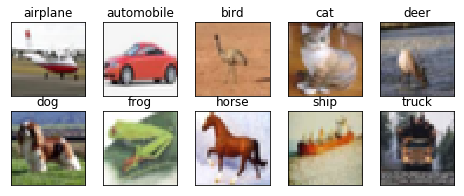

In [11]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

In [6]:
train_labels.shape
train_features.shape

(50000, 32, 32, 3)

In [18]:
shape_of_image = (32,32)+(3,)
input_image_shape = Input(shape = shape_of_image)

W0716 13:07:58.478067 139710379636608 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.



In [21]:
Input(shape = shape_of_image)

<tf.Tensor 'input_2:0' shape=(?, 32, 32, 3) dtype=float32>

In [0]:
def space_to_depth_x2(y):
  return tf.space_to_depth(y, block_size=2)

In [0]:

# Depthwise Separable Convolution with 5x5
x = SeparableConv2D(10,5,strides=1,padding='same',data_format='channels_last',use_bias=False)(img) #(5*5,32*32)
x = BatchNormalization(axis = 3)(x)
x = Activation('relu')(x)

skip_tensor1 = x

x = Conv2D(10,5,strides=1,padding='same',data_format='channels_last',use_bias=False)(x)#(9*9,32*32) of the form (effective global receptive field,output channel size )
x = BatchNormalization(axis = 3)(x)
x = Activation('relu')(x)

skip_tensor2 = x

x = Conv2D(10,5,strides=1,padding='same',data_format='channels_last',use_bias=False)(x)#(13*13,32*32) of the form (effective global receptive field,output channel size )
x = BatchNormalization(axis = 3)(x)
x = Activation('relu')(x)

skip_tensor3 = x

x = concatenate([skip_tensor1, x])

x = SeparableConv2D(10,5,strides=1,padding='same',data_format='channels_last',use_bias=False)(x) #(17*17,32*32)
x = BatchNormalization(axis = 3)(x)
x = Activation('relu')(x)

skip_tensor4 = x

#concatinating skip tensor
x = concatenate([skip_tensor1, x])

x =  MaxPooling2D(pool_size=(2,2),data_format='channels_last')(x) #(18*18,32*32)


x = SeparableConv2D(10,3,strides=1,padding='same',data_format='channels_last',use_bias=False)(x) #(22*22,16*16)
x = BatchNormalization(axis = 3)(x)
x = Activation('relu')(x)

skip_tensor5 = x

concat_1_4 = concatenate([skip_tensor1, skip_tensor4])#S
concat_1_4 = Lambda(space_to_depth_x2)(concat_1_4)
x = concatenate([concat_1_4, x])

x = Conv2D(10,5,strides=1,padding='same',data_format='channels_last',use_bias=False)(x)#(30*30,16*16) of the form (effective global receptive field,output channel size )
x = BatchNormalization(axis = 3)(x)
x = Activation('relu')(x)

skip_tensor6 = x

concat_3_4 = concatenate([skip_tensor3, skip_tensor4])
concat_3_4 = Lambda(space_to_depth_x2)(concat_3_4)
x = concatenate([concat_3_4, skip_tensor5, x])

x = SeparableConv2D(10,3,strides=1,padding='same',data_format='channels_last',use_bias=False)(x) #(34*34,16*16)
x = BatchNormalization(axis = 3)(x)
x = Activation('relu')(x)

skip_tensor7 = x

concat_1_3_4 = concatenate([skip_tensor1, skip_tensor3, skip_tensor4])
concat_1_3_4 = Lambda(space_to_depth_x2)(concat_1_3_4)
x = concatenate([concat_1_3_4, skip_tensor5, skip_tensor6, x])

x = SeparableConv2D(10,5,strides=1,padding='same',data_format='channels_last',use_bias=False)(x) #(42*42,16*16)
x = BatchNormalization(axis = 3)(x)
x = Activation('relu')(x)

skip_tensor8 = x

#concatinating
x = concatenate([concat_1_4, skip_tensor5, skip_tensor7, x])

x =  MaxPooling2D(pool_size=(2,2),data_format='channels_last')(x)#(44*44,8*8)


concat_6 = Lambda(space_to_depth_x2)(skip_tensor6)
x = concatenate([concat_6, x])

x = Conv2D(10,5,strides=1,padding='same',data_format='channels_last',use_bias=False)(x)#(60*60,8*8) 
x = BatchNormalization(axis = 3)(x)
x = Activation('relu')(x)

skip_tensor9 = x

concat_2_4 = concatenate([skip_tensor2, skip_tensor4])
concat_2_4 = Lambda(space_to_depth_x2)(concat_2_4)
concat_2_4 = Lambda(space_to_depth_x2)(concat_2_4)
concat_7 = Lambda(space_to_depth_x2)(skip_tensor7)
x = concatenate([concat_2_4, concat_7, x])

x = SeparableConv2D(10,5,strides=1,padding='same',data_format='channels_last',use_bias=False)(x) #(76*76,8*8)
x = BatchNormalization(axis = 3)(x)
x = Activation('relu')(x)

skip_tensor10 = x

concat_2_3 = concatenate([skip_tensor2, skip_tensor3])
concat_2_3 = Lambda(space_to_depth_x2)(concat_2_3)
concat_2_3 = Lambda(space_to_depth_x2)(concat_2_3)
concat_5 = Lambda(space_to_depth_x2)(skip_tensor5)
x = concatenate([concat_2_3, concat_5, skip_tensor9, x])

x = Conv2D(10,3,strides=1,padding='same',data_format='channels_last',use_bias=False)(x)#(84*84,8*8)
x = BatchNormalization(axis = 3)(x)
x = Activation('relu')(x)

skip_tensor11 = x

concat_1_3_4 = concatenate([skip_tensor1, skip_tensor3, skip_tensor4])
concat_1_3_4 = Lambda(space_to_depth_x2)(concat_1_3_4)
concat_1_3_4 = Lambda(space_to_depth_x2)(concat_1_3_4)
concat_5_7 = concatenate([skip_tensor5, skip_tensor7])
concat_5_7 = Lambda(space_to_depth_x2)(concat_5_7)
x = concatenate([concat_1_3_4, concat_5_7, skip_tensor10, x])

x = SeparableConv2D(10,5,strides=1,padding='same',data_format='channels_last',use_bias=False)(x) #(100*100,8*8)
x = BatchNormalization(axis = 3)(x)
x = Activation('relu')(x)

concat_4 = Lambda(space_to_depth_x2)(skip_tensor4)
concat_4 = Lambda(space_to_depth_x2)(concat_4)
concat_7 = Lambda(space_to_depth_x2)(skip_tensor7)
x = concatenate([concat_4, concat_7, skip_tensor10, x])

x = Conv2D(10, 1,strides=1,data_format='channels_last',use_bias=False)(x)
x = GlobalAveragePooling2D(data_format= 'channels_last')(x)
x = Flatten()
output = Activation('softmax')(x)


In [0]:
model = Model(inputs=img, outputs=output)

In [45]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
separable_conv2d_15 (SeparableC (None, 32, 32, 10)   105         input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_35 (BatchNo (None, 32, 32, 10)   40          separable_conv2d_15[0][0]        
__________________________________________________________________________________________________
activation_36 (Activation)      (None, 32, 32, 10)   0           batch_normalization_35[0][0]     
__________________________________________________________________________________________________
conv2d_24 

In [0]:
model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

In [0]:
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
def scheduler(epoch, lr):
  return round(0.003 * 1/(1 + 0.319 * epoch), 10)

callback = [LearningRateScheduler(scheduler, verbose=1)]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, callbacks=[<keras.ca..., steps_per_epoch=195, epochs=100)`
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. 

Epoch 1/100

Epoch 00001: LearningRateScheduler setting learning rate to 0.003.
195/195 [==============================] - 30s 155ms/step - loss: 0.8083 - acc: 0.7134 - val_loss: 1.1676 - val_acc: 0.5902
Epoch 2/100

Epoch 00002: LearningRateScheduler setting learning rate to 0.0022744503.
195/195 [==============================] - 30s 155ms/step - loss: 0.7295 - acc: 0.7409 - val_loss: 1.0766 - val_acc: 0.6332
Epoch 3/100

Epoch 00003: LearningRateScheduler setting learning rate to 0.0018315018.
195/195 [==============================] - 30s 154ms/step - loss: 0.6719 - acc: 0.7635 - val_loss: 1.1726 - val_acc: 0.6198
Epoch 4/100

Epoch 00004: LearningRateScheduler setting learning rate to 0.0015329586.
195/195 [==============================] - 30s 155ms/step - loss: 0.6291 - acc: 0.7780 - val_loss: 1.0428 - val_acc: 0.6555
Epoch 5/100

Epoch 00005: LearningRateScheduler setting learning rate to 0.0013181019.
195/195 [==============================] - 30s 154ms/step - loss: 0.5888 - a

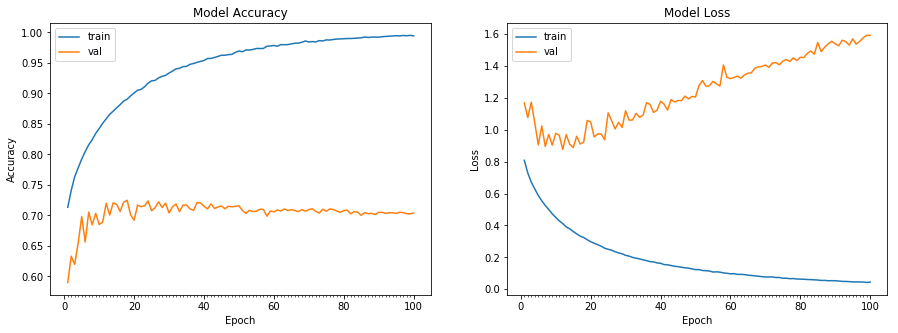

Accuracy on test data is: 70.39


In [49]:
datagen = ImageDataGenerator(featurewise_center=True,featurewise_std_normalization=True,data_format='channels_last')


# Training model
start = time.time()

model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 256),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 100, 
                                 validation_data = (test_features, test_labels), verbose=1,callbacks = callback )
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))